# Exploratory Data Analysis and Business Insights

In [155]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()
sns.set_theme(rc = {'figure.figsize':(15,8)}, style='whitegrid')

## Creating connection

In [14]:
db_url = os.getenv('DB_URL')
engine = create_engine(db_url)

## EDA and Business Insights

### 0. Period Filter

In [156]:
df_0 = pd.read_sql("""
    SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref, 
        COUNT(DISTINCT order_id) as tt_orders
    FROM fact_orders
    GROUP BY 1
    ORDER BY 1 ASC
""", con=engine)

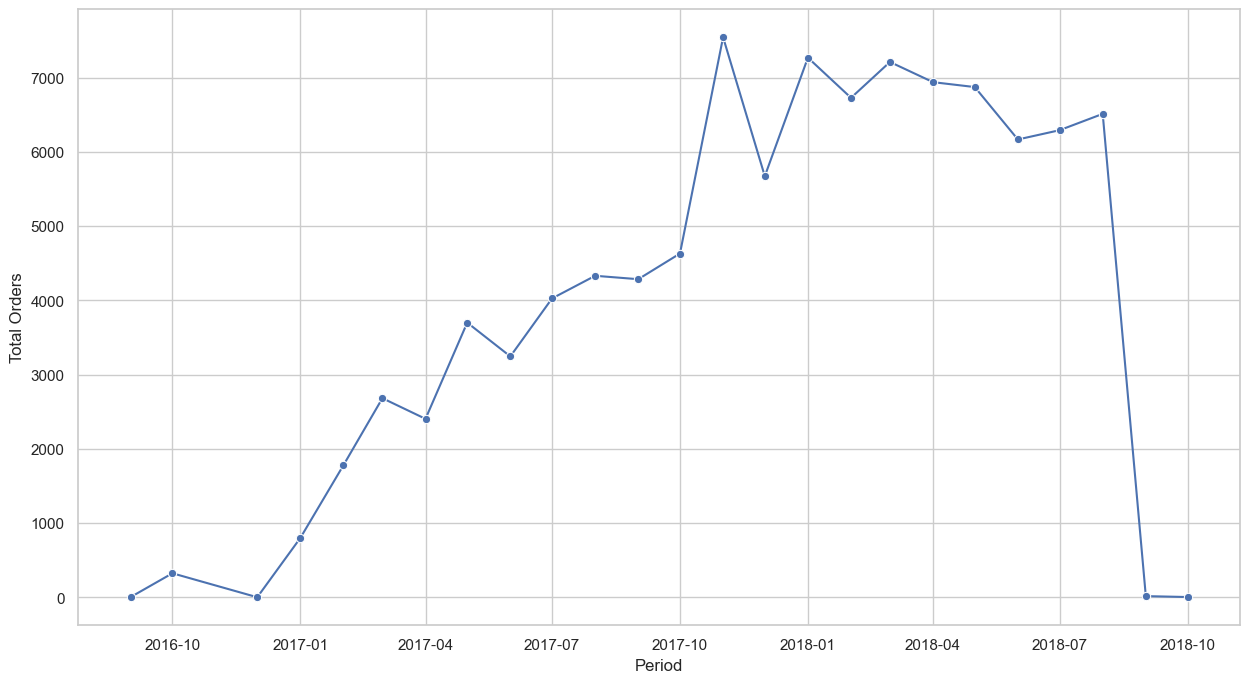

In [157]:
ax = sns.lineplot(data=df_0, x='dt_ref', y='tt_orders', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Total Orders');

Looking at the entire period of data, we can see that we have a bit of dirt at the beginning and at the end, so I'm going to do the analysis by applying a date filter, filtering orders between 2017-01-01 and 2018-08-31.

### 1. # of Orders and Customers Over Time

In [ ]:
df_1 = pd.read_sql("""
    SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref, 
        COUNT(DISTINCT order_id) as tt_orders,
        COUNT(DISTINCT unique_customer_id) as tt_customers
    FROM fact_orders
    WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
    GROUP BY 1
    ORDER BY 1 ASC
""", con=engine)

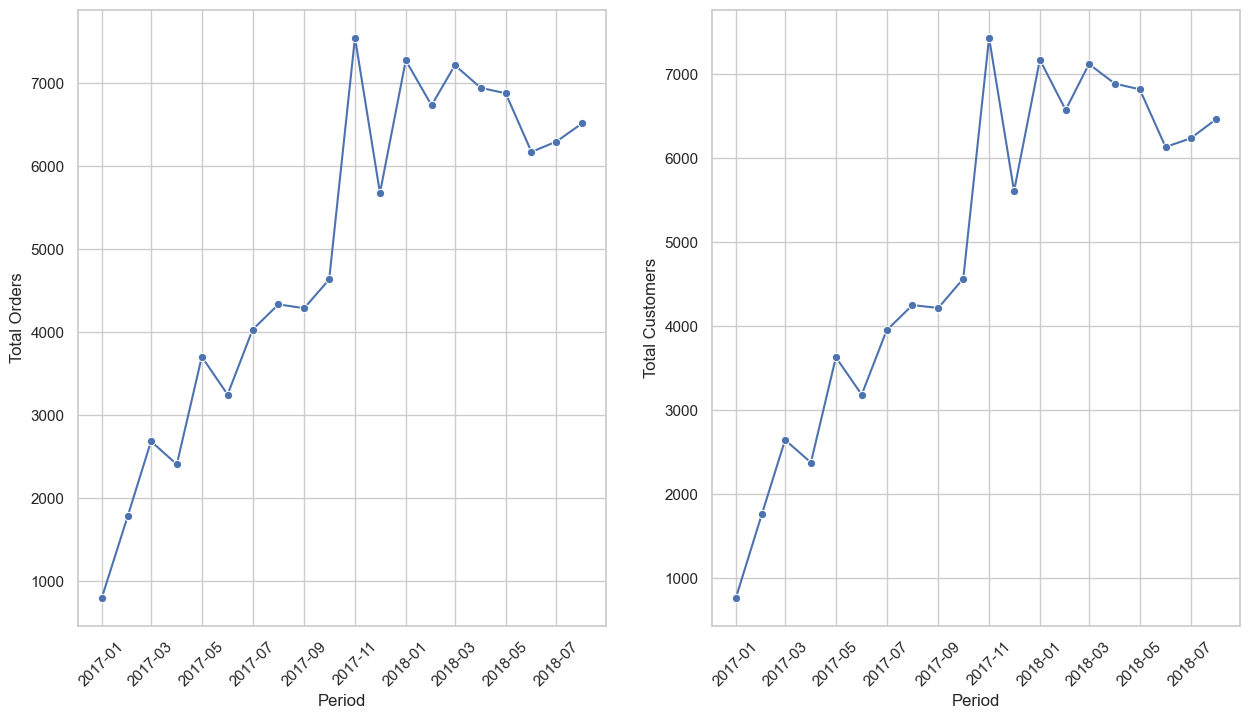

In [192]:
plt.subplot(1, 2, 1)
ax = sns.lineplot(data=df_1, x='dt_ref', y='tt_orders', marker='o')
plt.xticks(rotation = 45)
ax.set_xlabel('Period')
ax.set_ylabel('Total Orders')

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=df_1, x='dt_ref', y='tt_customers', marker='o')
plt.xticks(rotation = 45)
ax.set_xlabel('Period')
ax.set_ylabel('Total Customers');

Here we can see that the number of customers and orders is increasing over time practically at the same pace. There's a spike in November 2017, which can be explained by the Black Friday marketing and promotions.

Looking at this chart we can say that one customer usually places one order per month.

### 2. # of Orders per Day of the Week

In [193]:
df_2 = pd.read_sql("""
    SELECT DISTINCT TO_CHAR(purchase_ts, 'DAY') AS day_name,
        EXTRACT(ISODOW FROM purchase_ts) AS day_of_week,
        COUNT(DISTINCT order_id) as tt_orders
    FROM fact_orders
    WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
    GROUP BY 1,2
    ORDER BY 2 ASC
""", con=engine)

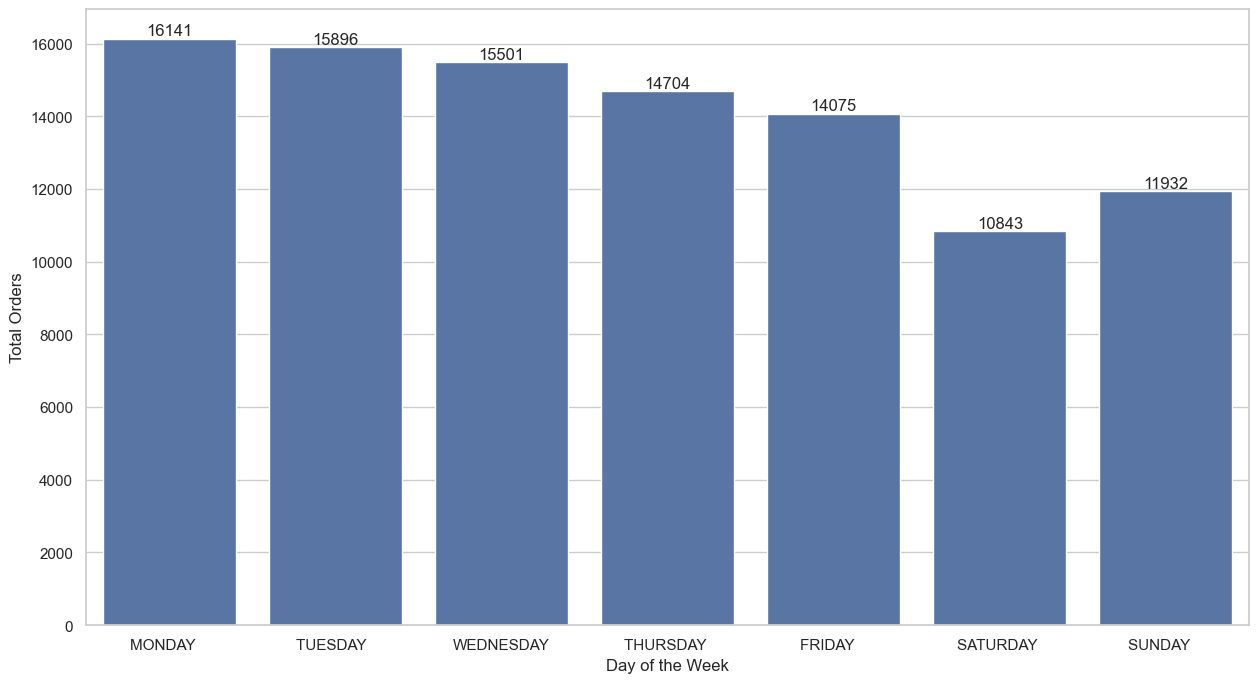

In [194]:
ax = sns.barplot(data=df_2, x='day_name', y='tt_orders')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Total Orders')
ax.bar_label(ax.containers[0], fontsize=12);

Looking at the whole period of the dataset, the day with most orders placed is Monday, and the day with the least orders placed is Saturday.

Let's see if historically this has always been customer behavior.

#### 2.1 Over Time

In [195]:
df_3 = pd.read_sql("""
    SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref, 
        TO_CHAR(purchase_ts, 'DAY') AS day_name,
        EXTRACT(ISODOW FROM purchase_ts) AS day_of_week,
        COUNT(DISTINCT order_id) as tt_orders
    FROM fact_orders
    WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
    GROUP BY 1,2,3
    ORDER BY 1, 3 ASC
""", con=engine)

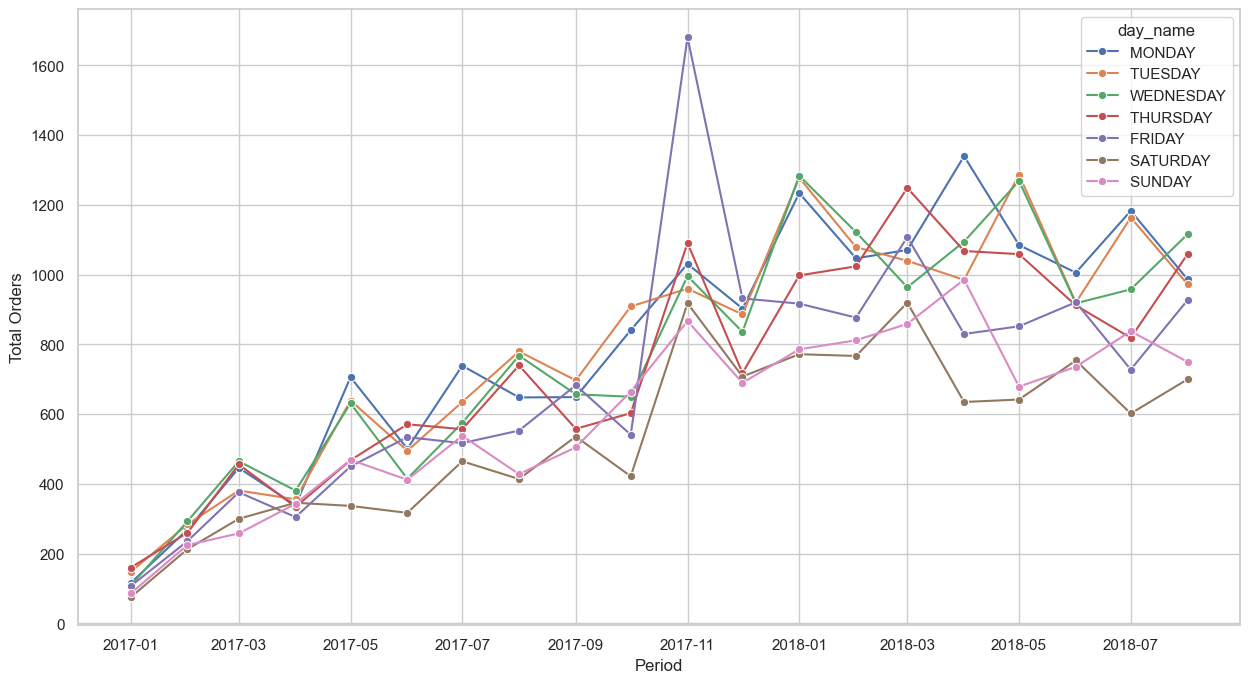

In [196]:
ax = sns.lineplot(data=df_3, x='dt_ref', y='tt_orders', hue='day_name', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Total Orders');

Only in a few periods Monday was the day with the most orders placed. But we can see in the previous chart that the number of orders placed week days is very similar. 

Here we can also see that in November 2017 the day of the week with most orders placed was Friday, proving the hypothesis raised above.

### 3. # of Orders per Period of the Day

In [197]:
df_4 = pd.read_sql("""
    WITH tb AS (
        SELECT DISTINCT EXTRACT(HOUR FROM purchase_ts) AS ref_hour,
            COUNT(DISTINCT order_id) as tt_orders
        FROM silver_orders
        WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
        GROUP BY 1
        ORDER BY 1 ASC
    ),
    final as (
    SELECT ref_hour, 
        CASE WHEN ref_hour BETWEEN 0 and 5 THEN 'Dawn'
            WHEN ref_hour BETWEEN 6 AND 12 THEN 'Morning'
            WHEN ref_hour BETWEEN 13 AND 18 THEN 'Afternoon'
            ELSE 'Night'
        END AS period_of_day,
        tt_orders
    FROM tb
    )
    SELECT period_of_day,
        SUM(tt_orders) as total_orders
    FROM final
    GROUP BY 1
""", con=engine)

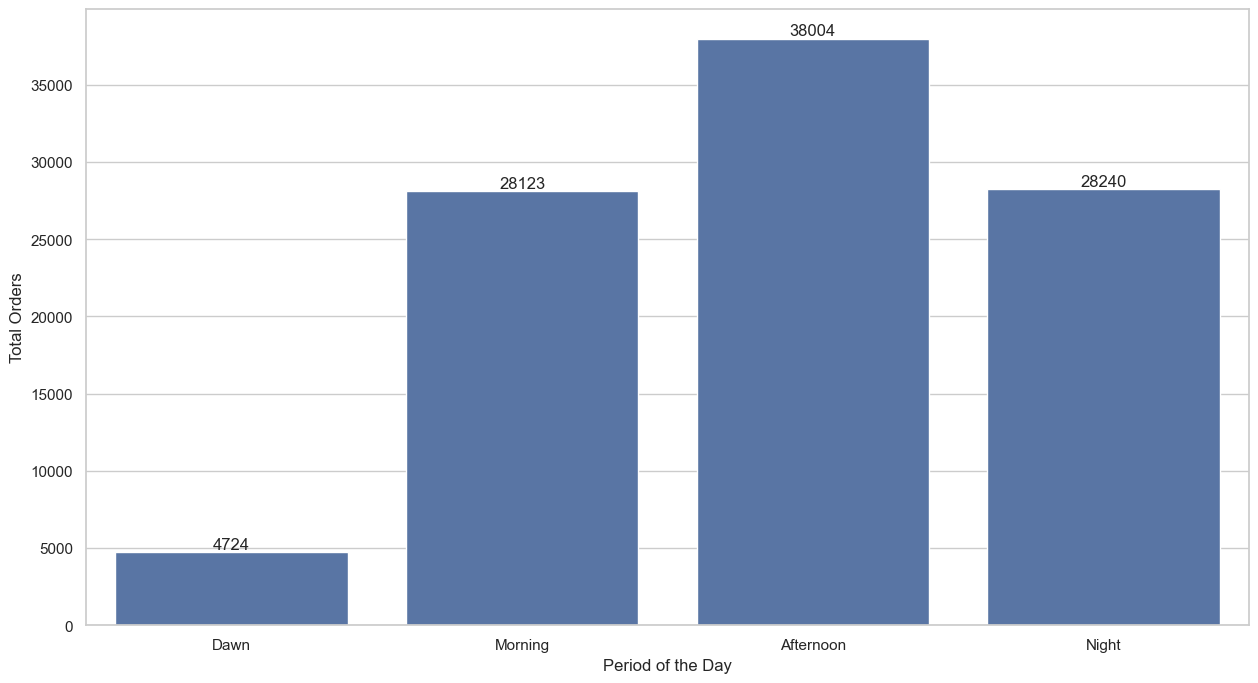

In [198]:
ax = sns.barplot(data=df_4, x='period_of_day', y='total_orders')
ax.set_xlabel('Period of the Day')
ax.set_ylabel('Total Orders')
ax.bar_label(ax.containers[0], fontsize=12);

Here we can see that the period of the day with most orders placed is in the Afternoon (1pm to 6pm), followed by Night (7pm to 11pm), Morning (6am to 12pm) and Dawn (12am to 5am).

Let's see if historically this has always been customer behavior.

#### 3.1 Over Time

In [199]:
df_5 = pd.read_sql("""
    WITH tb AS (
        SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref,  
            EXTRACT(HOUR FROM purchase_ts) AS ref_hour,
            COUNT(DISTINCT order_id) as tt_orders
        FROM silver_orders
        WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
        GROUP BY 1, 2
        ORDER BY 1, 2 ASC
    ),
    final as (
    SELECT DISTINCT dt_ref,
        ref_hour, 
        CASE WHEN ref_hour BETWEEN 0 and 5 THEN 'Dawn'
            WHEN ref_hour BETWEEN 6 AND 12 THEN 'Morning'
            WHEN ref_hour BETWEEN 13 AND 18 THEN 'Afternoon'
            ELSE 'Night'
        END AS period_of_day,
        tt_orders
    FROM tb
    )
    SELECT DISTINCT dt_ref,
        period_of_day,
        SUM(tt_orders) as total_orders
    FROM final
    GROUP BY 1, 2
""", con=engine)

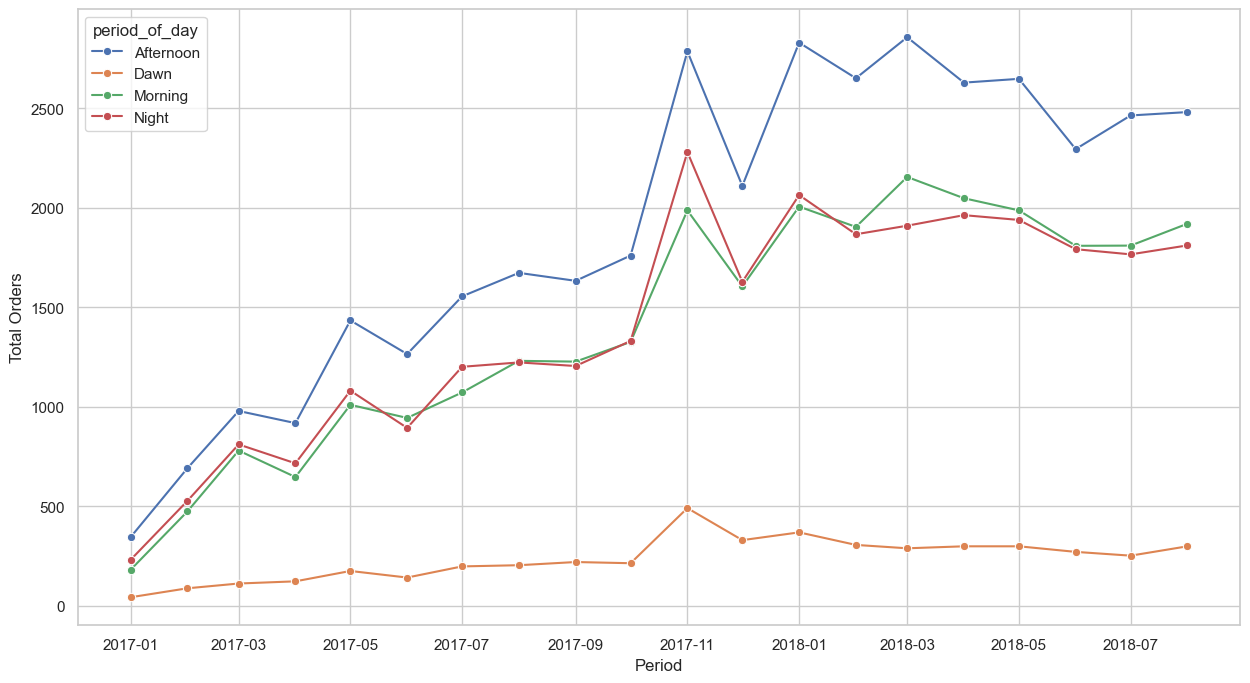

In [200]:
ax = sns.lineplot(data=df_5, x='dt_ref', y='total_orders', hue='period_of_day', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Total Orders');

Yes, historically the customers placed more orders in the Afternoon, with Night and Morning swapping places in the second position.

### 4. # of Orders per Region

In [201]:
df_6 = pd.read_sql("""
    SELECT DISTINCT customer_state, 
      CASE WHEN customer_state IN ('SC', 'RS', 'PR') THEN 'Sul'
        WHEN customer_state IN ('SP', 'RJ', 'ES', 'MG') THEN 'Sudeste'
        WHEN customer_state IN ('MT', 'MS', 'GO', 'DF') THEN 'Centro-Oeste'
        WHEN customer_state IN ('MA', 'PI', 'BA', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE') THEN 'Nordeste'
        ELSE 'Norte'
        END AS customer_region, 
      COUNT(DISTINCT order_id) as tt_orders,
      COUNT(DISTINCT unique_customer_id) as tt_customers
    FROM fact_orders
    WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
    GROUP BY 1, 2
    ORDER BY 1 ASC
""", con=engine)

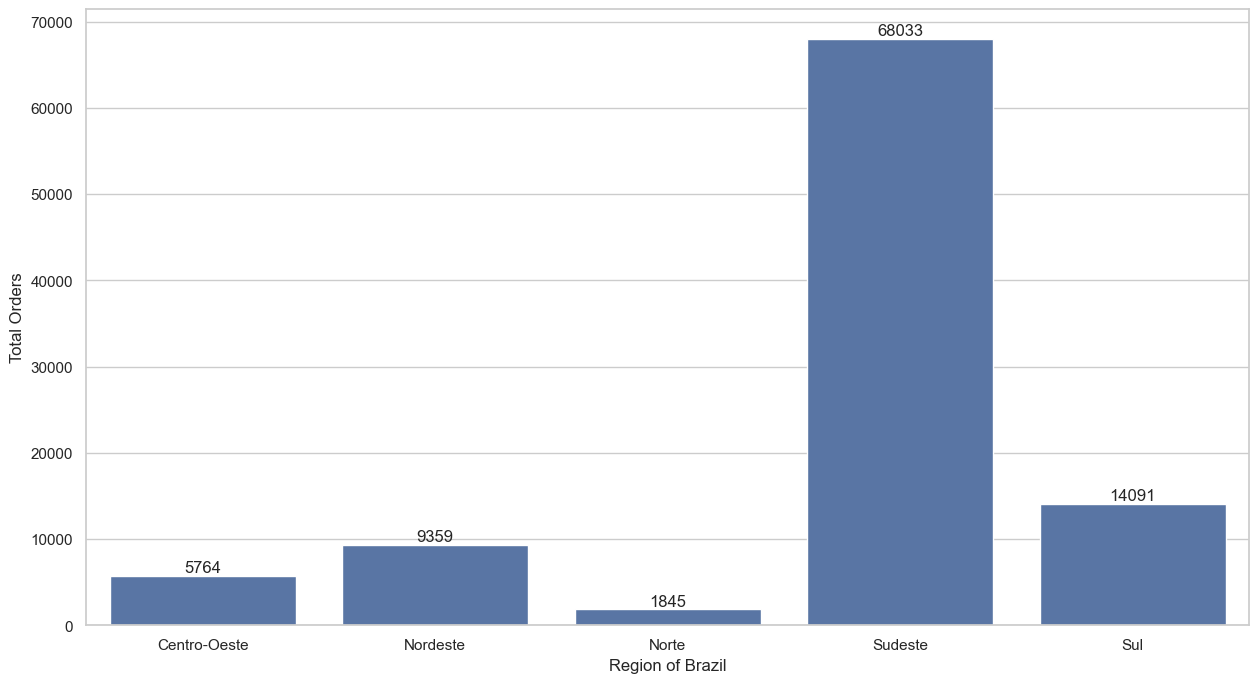

In [202]:
df_6_aux = df_6[['customer_region', 'tt_orders', 'tt_customers']].groupby('customer_region').sum().reset_index()

ax = sns.barplot(data=df_6_aux, x='customer_region', y='tt_orders')
ax.set_xlabel('Region of Brazil')
ax.set_ylabel('Total Orders')
ax.bar_label(ax.containers[0], fontsize=12);

Sudeste is the most populous region in Brazil, so it makes sense that the largest number of orders would come from there. And the region with the least orders placed is Norte, which also makes sense, since the logistics for that region can be very expensive.

#### 4.1 Over Time

In [203]:
df_7 = pd.read_sql("""
    SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref,
      customer_state, 
      CASE WHEN customer_state IN ('SC', 'RS', 'PR') THEN 'Sul'
        WHEN customer_state IN ('SP', 'RJ', 'ES', 'MG') THEN 'Sudeste'
        WHEN customer_state IN ('MT', 'MS', 'GO', 'DF') THEN 'Centro-Oeste'
        WHEN customer_state IN ('MA', 'PI', 'BA', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE') THEN 'Nordeste'
        ELSE 'Norte'
        END AS customer_region, 
      COUNT(DISTINCT order_id) as tt_orders,
      COUNT(DISTINCT unique_customer_id) as tt_customers
    FROM fact_orders
    WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
    GROUP BY 1, 2, 3
    ORDER BY 1, 2 ASC
""", con=engine)

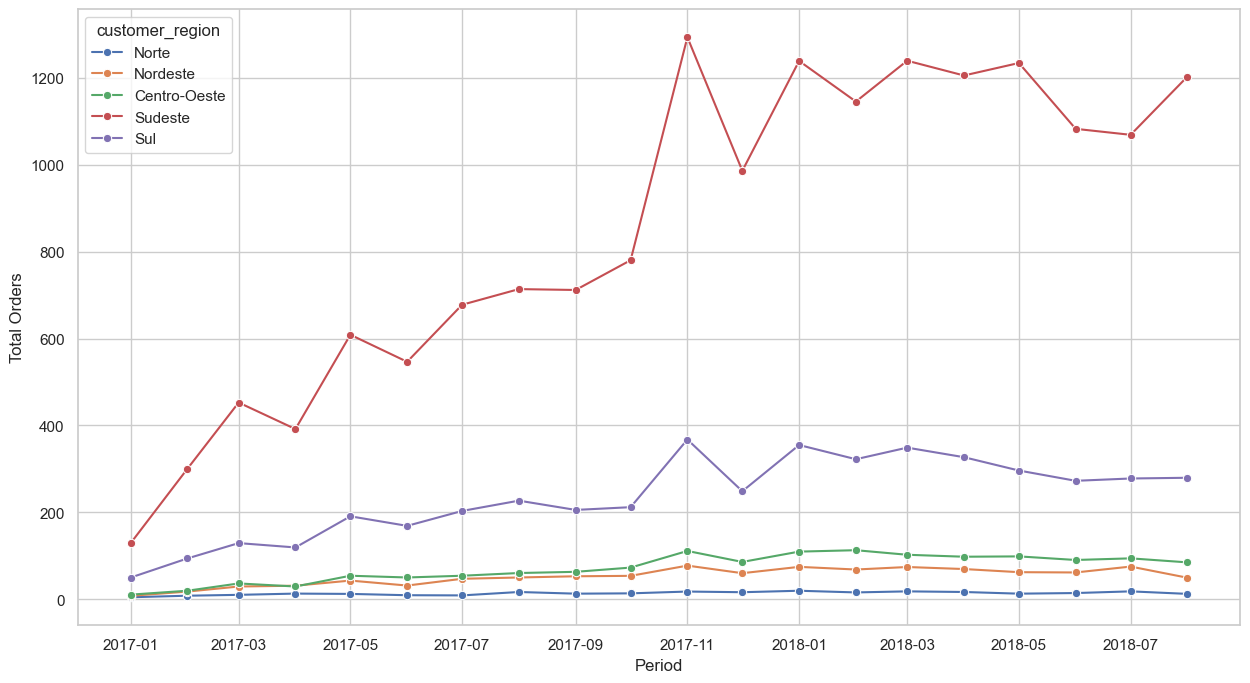

In [204]:
ax = sns.lineplot(data=df_7, x='dt_ref', y='tt_orders', hue='customer_region', marker='o', errorbar=None)
ax.set_xlabel('Period')
ax.set_ylabel('Total Orders');

And historically Sudeste is by far the region with most orders placed.

### 5. Top 10 States (# of Orders)

In [205]:
df_8 = pd.read_sql("""
    SELECT DISTINCT customer_state,
      COUNT(DISTINCT order_id) AS tt_orders
    FROM fact_orders
    WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
""", con=engine)

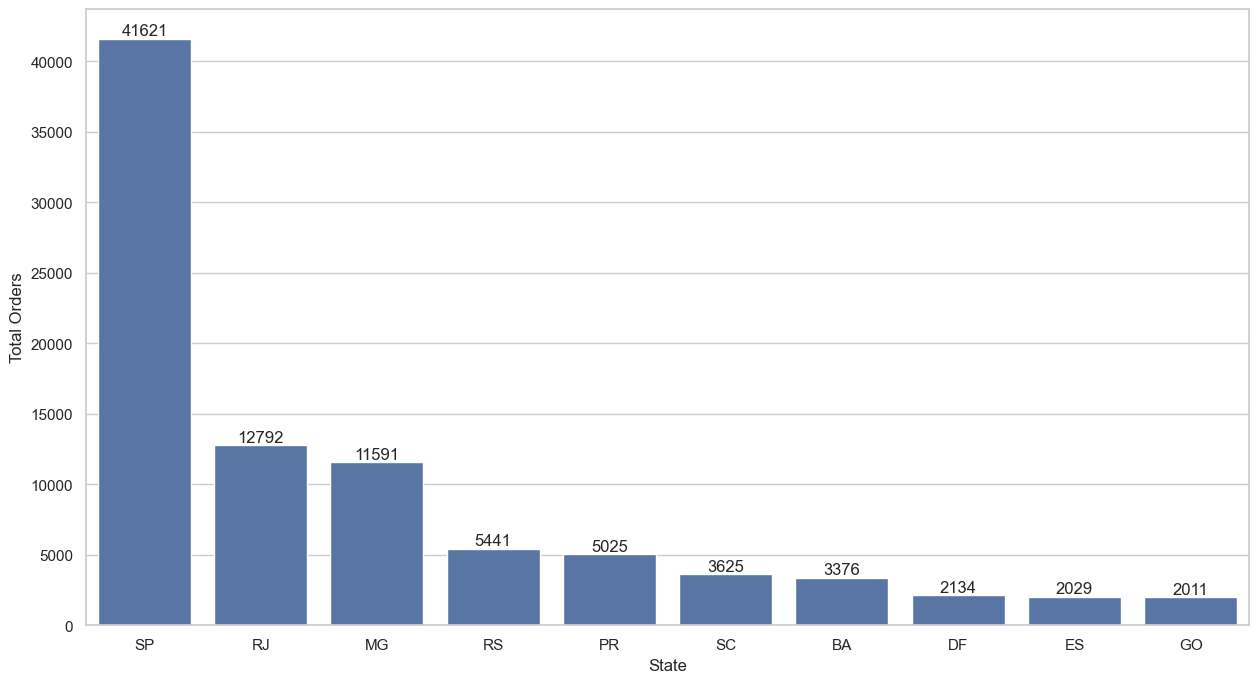

In [206]:
ax = sns.barplot(data=df_8, x='customer_state', y='tt_orders')
ax.set_xlabel('State')
ax.set_ylabel('Total Orders')
ax.bar_label(ax.containers[0], fontsize=12);

The top 3 States with more orders are in the Sudeste, followed by the 3 states from the region Sul. 

I'm not going to look at the number of Customers per state, since we saw above that the relation between the number of customers and orders is the same.

### 6. Top 10 Cities (# of Orders)

In [207]:
df_9 = pd.read_sql("""
    SELECT DISTINCT customer_city,
      COUNT(DISTINCT order_id) AS tt_orders
    FROM fact_orders
    WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
""", con=engine)

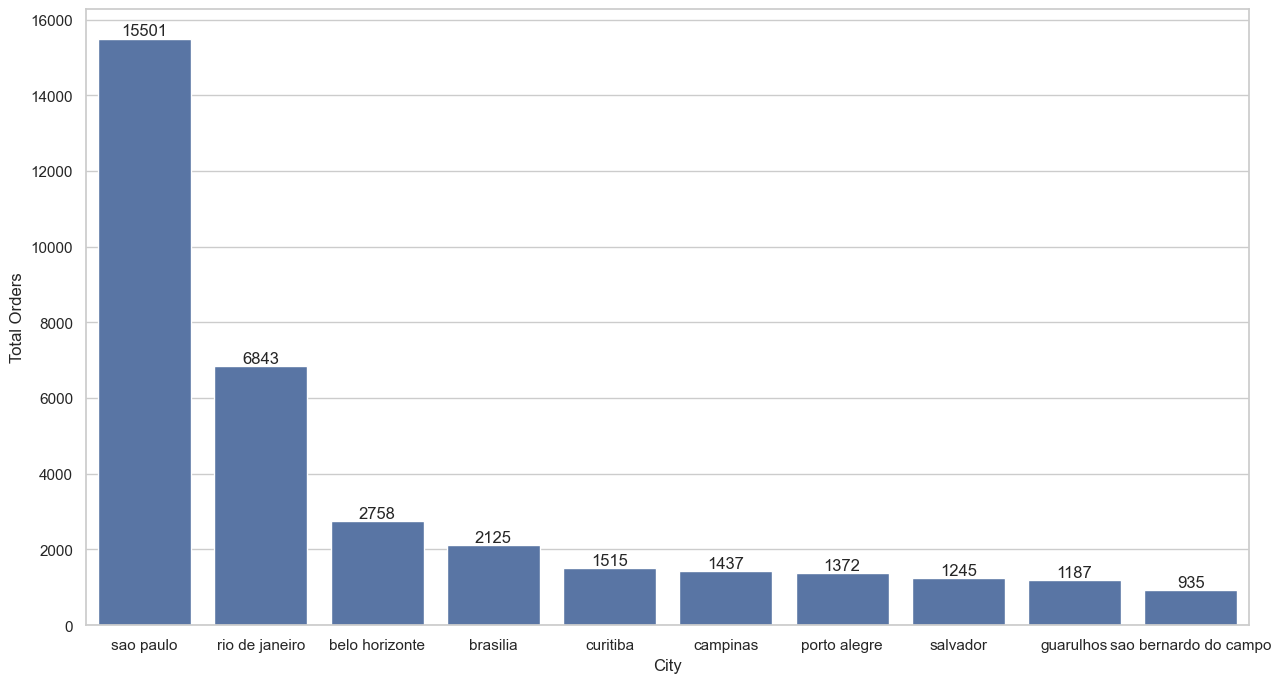

In [208]:
ax = sns.barplot(data=df_9, x='customer_city', y='tt_orders')
ax.set_xlabel('City')
ax.set_ylabel('Total Orders')
ax.bar_label(ax.containers[0], fontsize=12);

The top 3 Cities with more orders are the capitals from the top 3 states with more orders, followed by Brasil's capital, Brasilia. The majority of cities in this top 10 are in the Sudeste region.

I'm not going to look at the number of Customers per city, since we saw above that the relation between the number of customers and orders is the same.

### 7. GMV Over Time

In [209]:
df_10 = pd.read_sql("""
    SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref, 
        SUM(total_price) as tt_gmv
    FROM fact_orders
    WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
    GROUP BY 1
    ORDER BY 1 ASC
""", con=engine)

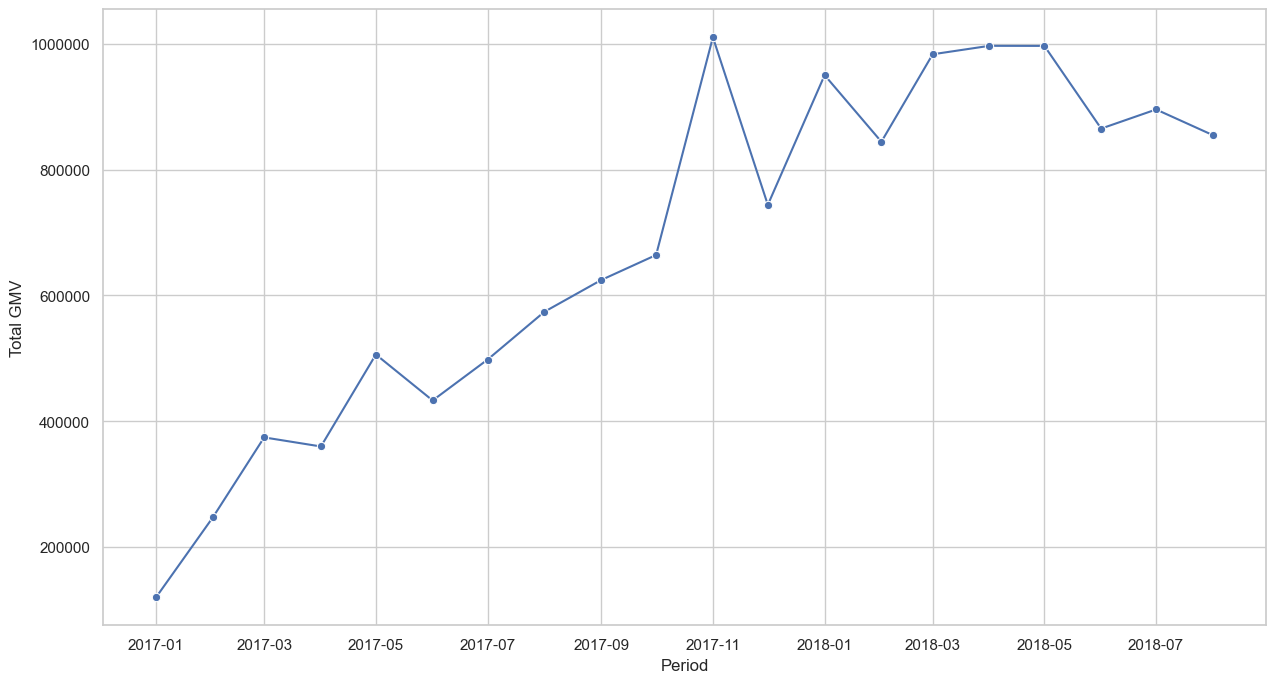

In [210]:
ax = sns.lineplot(data=df_10, x='dt_ref', y='tt_gmv', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Total GMV')
plt.ticklabel_format(style='plain', axis='y')
plt.show();

Following the same behavior from the number of Customers and Orders over time, here we can also see an increase in GMV over time.

### 8. Average Ticket per Order Over Time

In [216]:
df_11 = pd.read_sql("""
    WITH tb AS (
      SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref, 
          SUM(total_price) as tt_gmv, 
          COUNT(DISTINCT order_id) as tt_orders
      FROM fact_orders
      WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
      GROUP BY 1
      ORDER BY 1 ASC
    )
    SELECT DISTINCT dt_ref, 
      tt_gmv, 
      tt_orders, 
      tt_gmv / tt_orders AS avg_ticket_order
    FROM tb
""", con=engine)

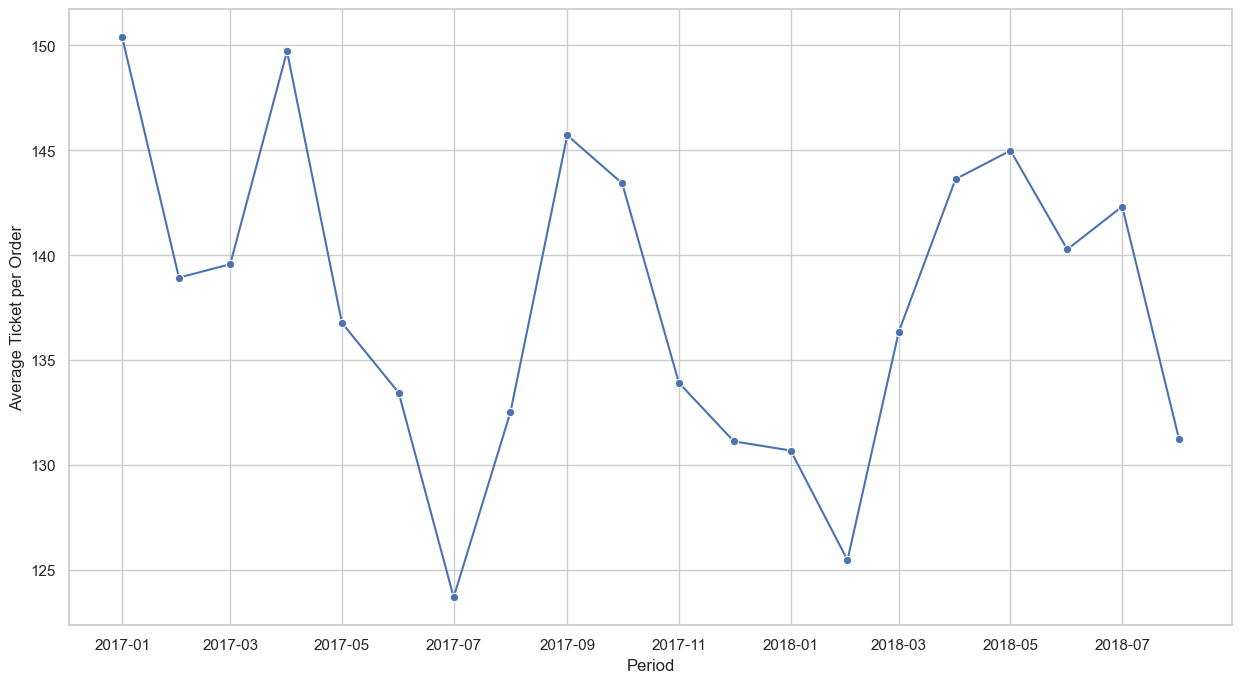

In [217]:
ax = sns.lineplot(data=df_11, x='dt_ref', y='avg_ticket_order', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Average Ticket per Order')
plt.ticklabel_format(style='plain', axis='y')
plt.show();

Unlike the other charts, here we can see that the average ticket per order fell in the period under analysis, which shows that we have more customers and orders, but they are buying less. 

### 9. # of Payments by Payment Type

In [219]:
df_12 = pd.read_sql("""
    SELECT DISTINCT p.method, 
      COUNT(*) as tt_payments, 
      COUNT(DISTINCT p.order_id) as tt_orders
    FROM silver_payments AS p
    LEFT JOIN fact_orders AS o
      on p.order_id = o.order_id
    WHERE o.purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
    GROUP BY 1
    ORDER BY 2 DESC
""", con=engine)

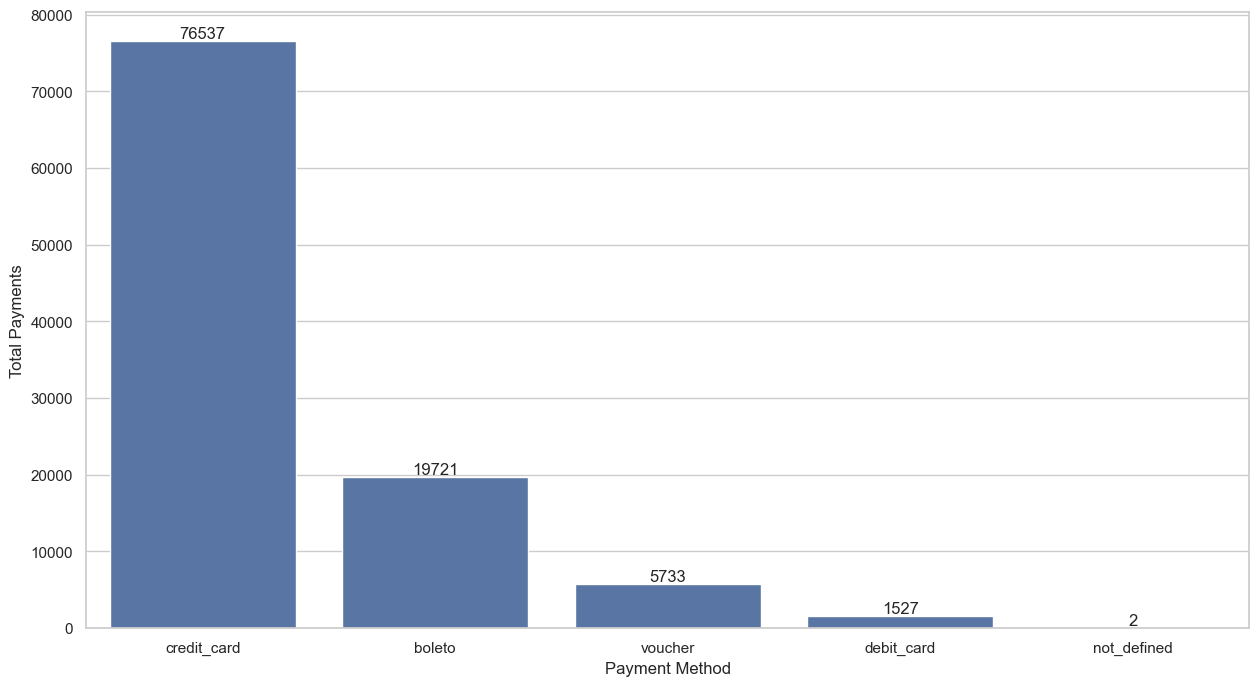

In [220]:
ax = sns.barplot(data=df_12, x='method', y='tt_payments')
ax.set_xlabel('Payment Method')
ax.set_ylabel('Total Payments')
ax.bar_label(ax.containers[0], fontsize=12);

The credit card is the payment method most used by customers, by far. 

Let's see if historically this has always been the favorite payment method.

#### 9.1 Over Time

In [221]:
df_13 = pd.read_sql("""
  WITH pay AS (
    SELECT DISTINCT order_id, 
      method
    FROM silver_payments
  ),
  orders AS (
    SELECT DISTINCT order_id, 
      purchase_ts
    FROM fact_orders
    WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
  ),
  joined AS (
    SELECT p.order_id, 
      p.method, 
      o.purchase_ts
    FROM pay AS p
    LEFT JOIN orders AS o
      ON p.order_id = o.order_id
  )  
  SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref,
    method, 
    COUNT(*) as tt_payments, 
    COUNT(DISTINCT order_id) as tt_orders   
  FROM joined
  GROUP BY 1, 2
  ORDER BY 1 ASC
""", con=engine)

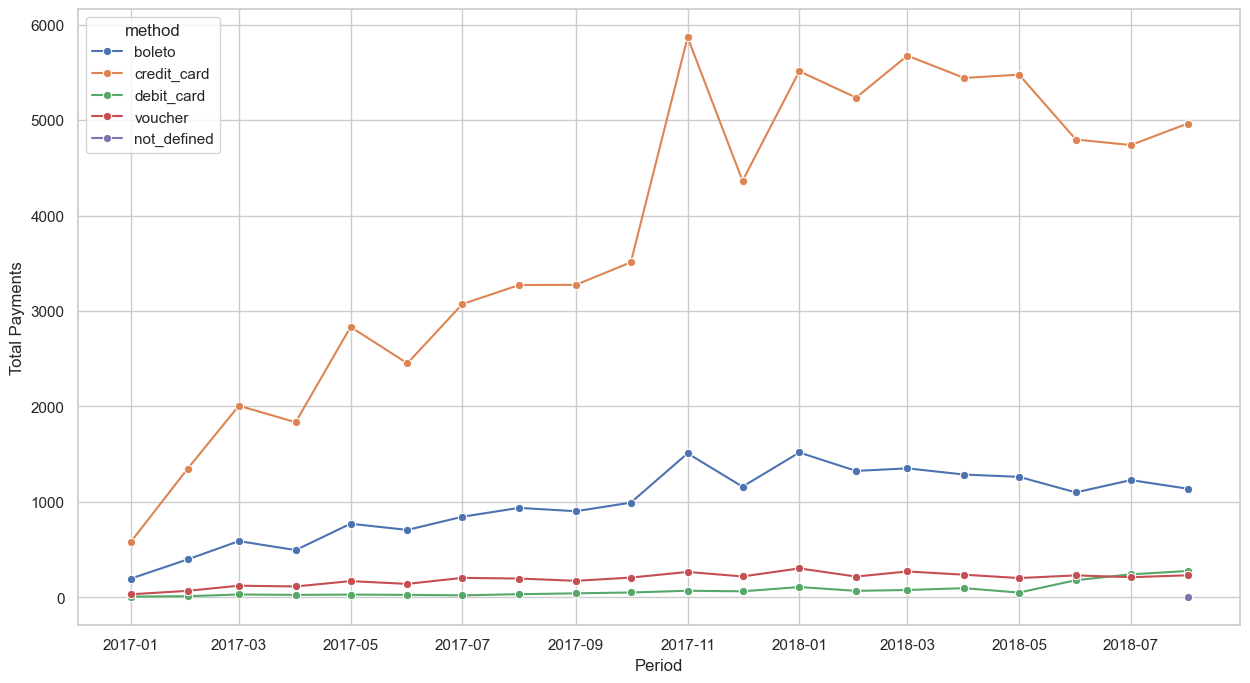

In [222]:
ax = sns.lineplot(data=df_13, x='dt_ref', y='tt_payments', hue='method', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Total Payments')
plt.ticklabel_format(style='plain', axis='y')
plt.show();

Yes, credit card has always been the favorite payment method.

### 10. # of Active Sellers Over Time

In [223]:
df_14 = pd.read_sql("""
  SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref,
    COUNT(DISTINCT seller_id) as tt_sellers   
  FROM fact_order_items
  WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
  GROUP BY 1
  ORDER BY 1 ASC
""", con=engine)

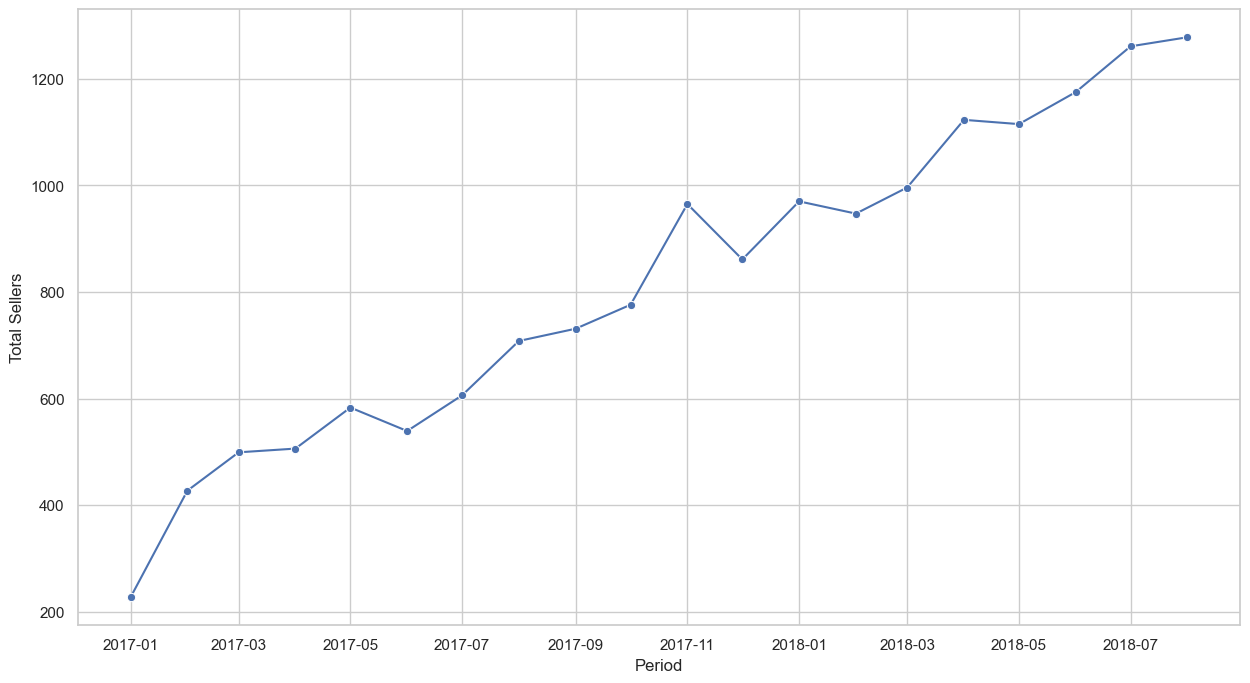

In [224]:
ax = sns.lineplot(data=df_14, x='dt_ref', y='tt_sellers', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Total Sellers')
plt.ticklabel_format(style='plain', axis='y')
plt.show();

As well as the number of orders and customers, we have an increase in the number of sellers on the platform in the period.

### 11. Top 10 Categories (# of Orders)

In [227]:
df_15 = pd.read_sql("""
  SELECT DISTINCT category_name,
    COUNT(DISTINCT order_id) as tt_orders   
  FROM fact_order_items
  WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
  GROUP BY 1
  ORDER BY 2 DESC
  LIMIT 10
""", con=engine)

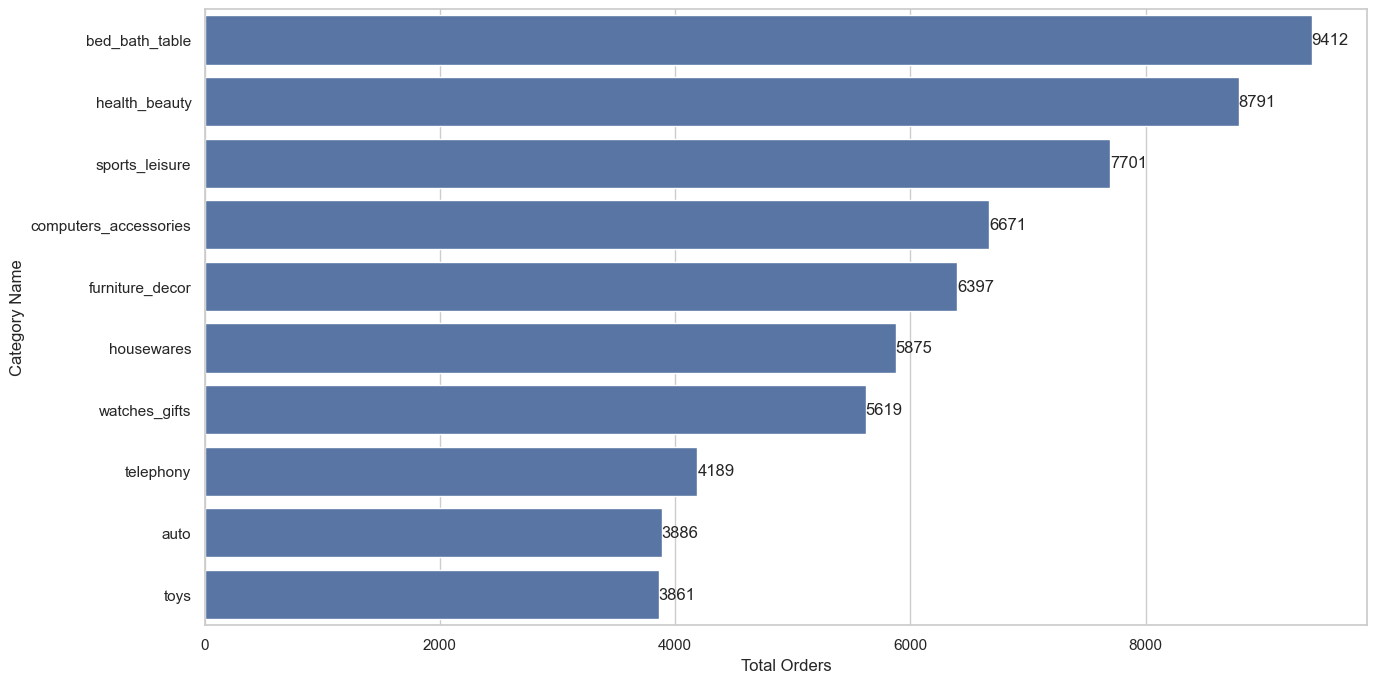

In [228]:
ax = sns.barplot(data=df_15, x='tt_orders', y='category_name', orient='h')
ax.set_xlabel('Total Orders')
ax.set_ylabel('Category Name')
ax.bar_label(ax.containers[0], fontsize=12);

Nothing to highlight here, normal numbers and no points of attention.

### 12. % of Orders with 5 Review Score Over Time

In [229]:
df_16 = pd.read_sql("""
    WITH tb AS (
        SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref, 
            COUNT(DISTINCT order_id) as tt_orders, 
            COUNT(DISTINCT CASE WHEN avg_score = 5 THEN order_id END) AS tt_orders_max_score
        FROM fact_orders
        WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
        GROUP BY 1
        ORDER BY 1 ASC
    )
    SELECT DISTINCT dt_ref, 
        tt_orders,
        tt_orders_max_score, 
        (tt_orders_max_score / tt_orders::float) * 100 as pct_max_score
    FROM tb
""", con=engine)

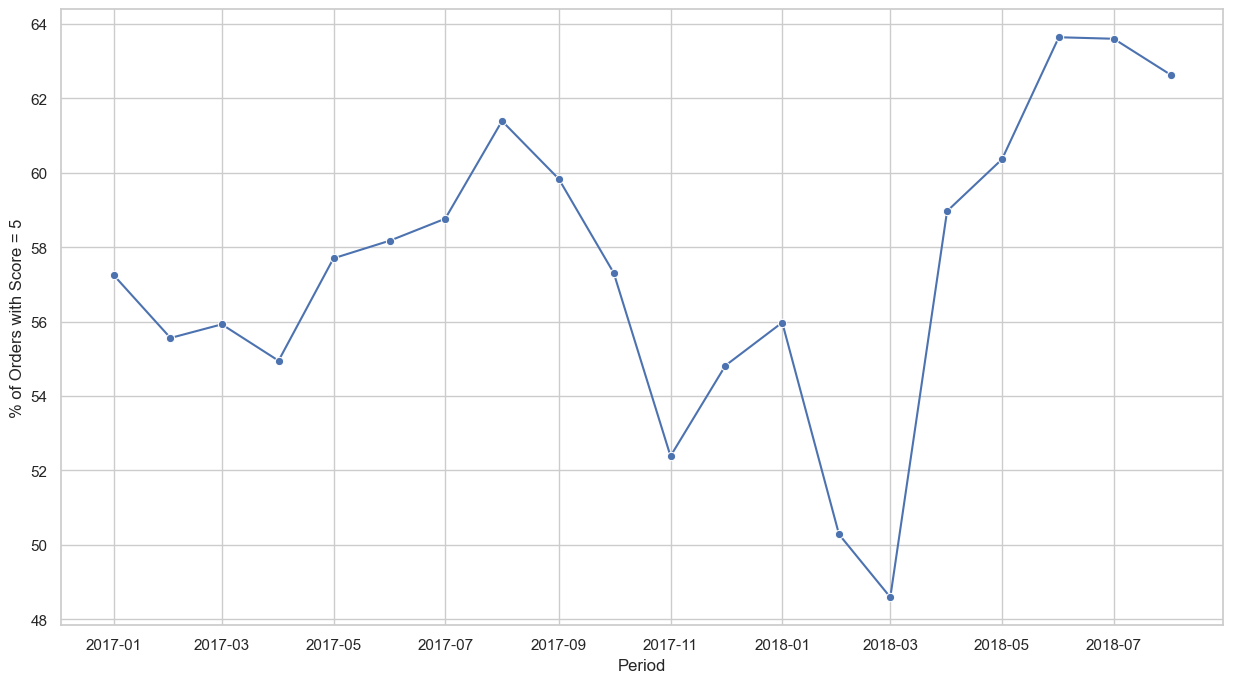

In [230]:
ax = sns.lineplot(data=df_16, x='dt_ref', y='pct_max_score', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('% of Orders with Score = 5');

Here we can see that the % of orders with a review score of 5 has always been high, but there was a drop in March 2018, followed by a substantial increase in April 2018.

### 13. Average Days to Deliver Over Time

In [232]:
df_17 = pd.read_sql("""
    SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref, 
        AVG(days_to_deliver) AS avg_days_to_deliver
    FROM fact_orders
    WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
    GROUP BY 1
    ORDER BY 1 ASC
""", con=engine)

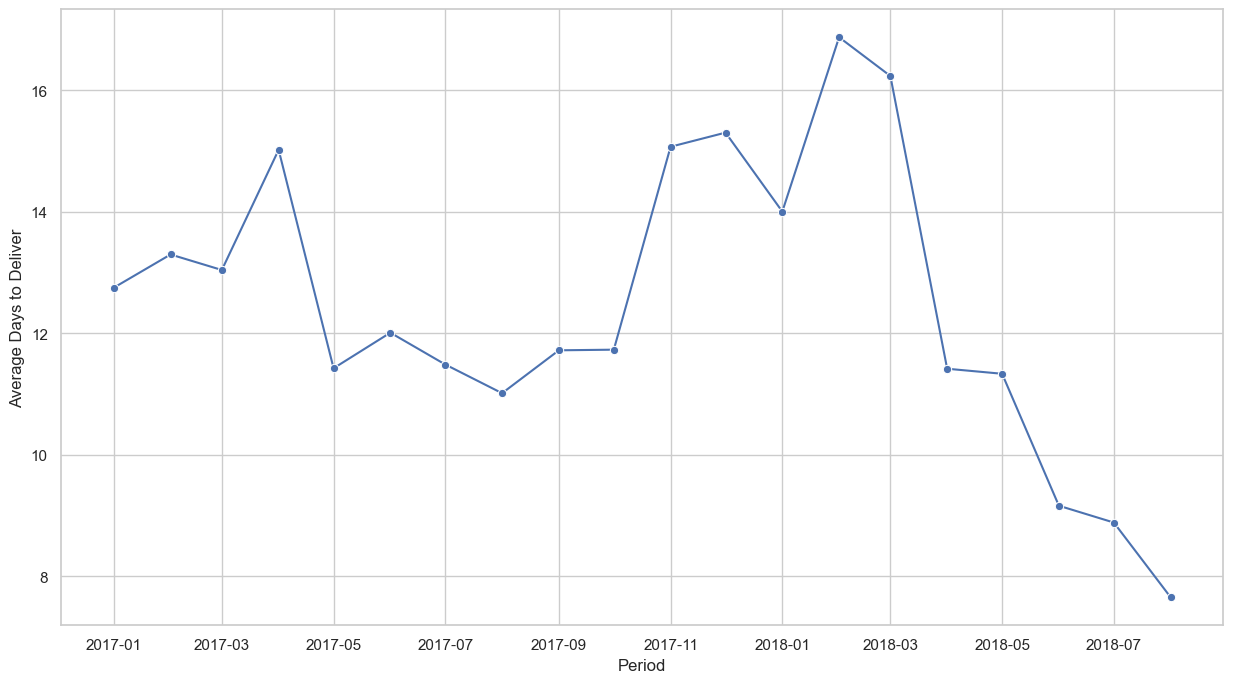

In [233]:
ax = sns.lineplot(data=df_17, x='dt_ref', y='avg_days_to_deliver', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Average Days to Deliver');

The average days to deliver has its ups and downs, but in the last few months of the period under analysis we can see a downward trend in this number.

### 14. Average Items per Order

In [234]:
df_18 = pd.read_sql("""
    WITH tb AS (
        SELECT DISTINCT order_id, 
            purchase_ts, 
            SUM(order_item_number) AS items_qty
        FROM fact_order_items
        WHERE purchase_ts BETWEEN '2017-01-01' AND '2018-08-31'
        GROUP BY 1, 2
    )    
    SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref, 
        AVG(items_qty) AS avg_items_per_order
    FROM tb
    GROUP BY 1
    ORDER BY 1 ASC
""", con=engine)

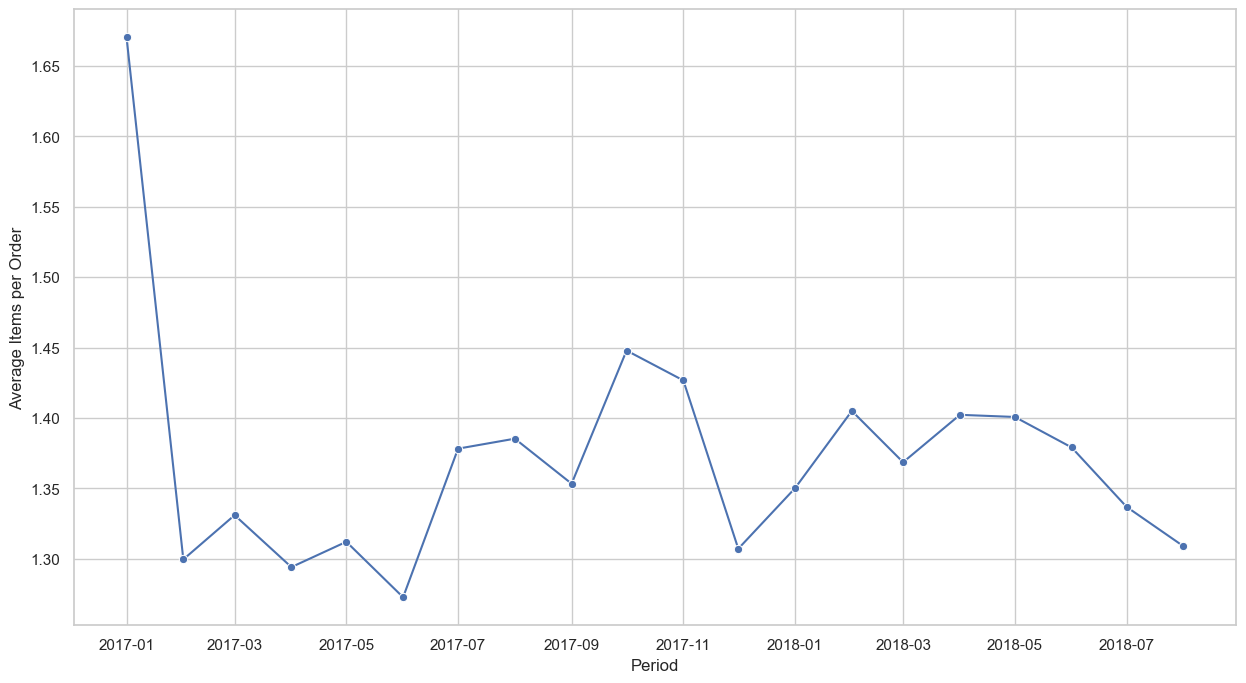

In [235]:
ax = sns.lineplot(data=df_18, x='dt_ref', y='avg_items_per_order', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Average Items per Order');

Finally, the average number of items per order has always been around 1.